# In this Notebook, a model of the ***thylakoid system*** of chloroplasts is built using ***PyVista*** using as reference a cryo-EM structure.

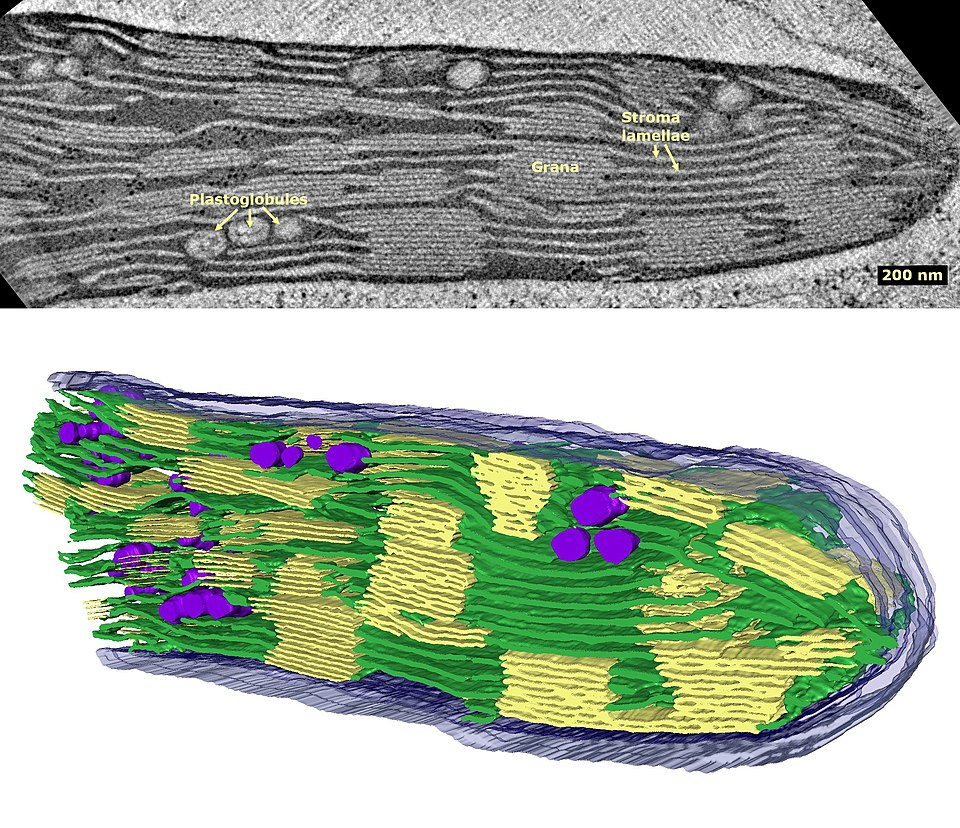

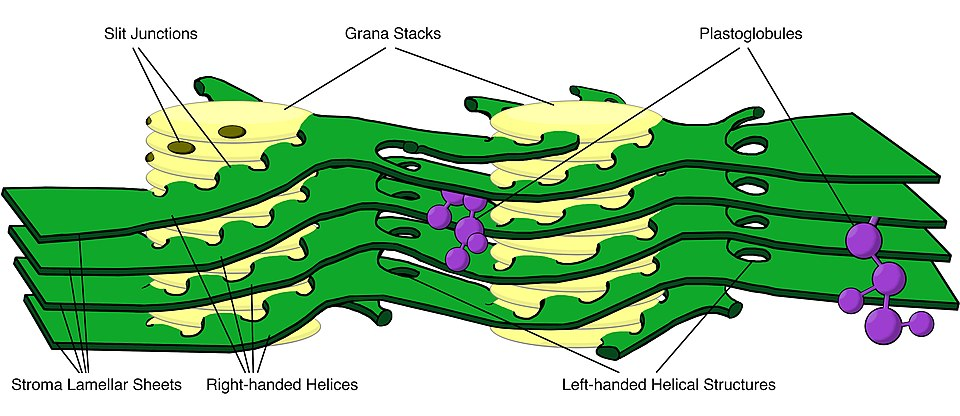

### References:
`Images and cryo-EM data`: Bussi, Y., Shimoni, E., Weiner, A., Kapon, R., Charuvi, D., Nevo, R., ... & Reich, Z. (2019). Fundamental helical geometry consolidates the plant photosynthetic membrane. Proceedings of the National Academy of Sciences, 116(44), 22366-22375.

# Install the required packages


In [ ]:
#!pip install pyvista
#!pip install pyacvd
#!pip install trame trame-client trame-server trame-vtk
#!pip install trame-vuetify trame-components # Install UI components including vuetify
#!pip install trame-plotly trame-vega # Install additional packages that might be required
#!pip install MDAnalysis
#!pip install trimesh

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.8-cp310-cp310-macosx_11_0_arm64.whl.metadata (6.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 MB 32.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 27.3 MB/s eta 0:00:00a 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 34.1 MB/s eta 0:00:00
Using cached kiwisolver-1.4.8-cp310-cp310-macosx_11_0_arm64.whl (65 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12/12 [pyvista]1/12 [pyvista]ib]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [pyacvd]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.5/750.5 kB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

# Import the libraries

In [1]:
from pyvista import examples
import pyacvd
import matplotlib.pyplot as plt
import numpy as np
import trimesh

ModuleNotFoundError: No module named 'pyvista'

# Load the Fucntions

In [24]:
def print_faces_area(mesh):
    """
    Print the statistics of the faces' area of a mesh.
    Parameters
    ----------
    mesh : pyvista.PolyData
        The mesh to analyze.
    Returns
    -------
    area : np.ndarray
        The area of the faces.
    """
    area = mesh.compute_cell_sizes().cell_data['Area']
    print(f"Number of faces: {area.size}")
    print(f"Mean area: {area.mean()}")
    print(f"Std area: {area.std()}")
    print(f"Min area: {area.min()}")
    print(f"Max area: {area.max()}")
    return area

#Function to plot the area histogram
def plot_area_histogram(list_area):
    """
    Compare the area of the faces of two meshes

    Parameters
    ----------
    list_area : list
        List of arrays containing the areas of the faces of two meshes
    ----------
    Returns
    -------
    None
    """
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Create histogram for each mesh
    for i, area in enumerate(list_area):
        ax.hist(area, bins=100, alpha=0.5, label=f'Mesh {i+1}')

    # Add labels and title
    ax.set_xlabel('Area')
    ax.set_ylabel('Frequency')
    ax.set_title('Area Histogram')
    ax.legend()

    # Show the plot
    plt.show()

def remesh_surface(mesh, n_points=20000, subdivision=1):
    """
    Remesh a surface to have more uniform triangle distribution using ACVD algorithm.
    
    Parameters
    ----------
    mesh : pyvista.PolyData
        Input mesh to be remeshed.
    
    n_points : int, default: 20000
        Target number of points for the remeshed surface.
    
    subdivision : int, default: 1
        Number of subdivisions to perform before clustering.
        Higher values create more input points for potentially better results.
    
    Returns
    -------
    pyvista.PolyData
        Remeshed surface with more uniform triangle distribution.
    
    Notes
    -----
    This function uses the Approximated Centroidal Voronoi Diagrams (ACVD)
    algorithm to create a more uniform triangulation of the input mesh.
    
    Examples
    --------
    >>> import pyvista as pv
    >>> from pyvista import examples
    >>> # Download example mesh
    >>> mesh = examples.download_cow()
    >>> # Remesh with 5000 points
    >>> uniform_mesh = remesh_surface(mesh, n_points=5000)
    """
    import pyacvd
    
    # Create the clustering object
    clus = pyacvd.Clustering(mesh)
    
    # Subdivide mesh for better clustering results if requested
    if subdivision > 1:
        clus.subdivide(subdivision)
    
    # Generate clusters
    clus.cluster(n_points)
    
    # Generate and return remeshed surface
    remeshed = clus.create_mesh()
    
    return remeshed

In [25]:
def simple_vertical_helix(height=10, radius=5, turns=3, n_points=100, handedness="right"):
    """
    Generate a simple vertical helix along the z-axis with specified handedness.

    Parameters
    ----------
    height : float, default: 10
        Total height of the helix.
        
    radius : float, default: 5
        Radius of the helix.
        
    turns : int or float, default: 3
        Number of complete turns in the helix.
        
    n_points : int, default: 100
        Number of points to generate along the helix.

    handedness : str, default: "right"
        Handedness of the helix. Must be either "right" or "left".
        Right-handed helix turns clockwise as it moves away from the viewer.
        Left-handed helix turns counter-clockwise as it moves away from the viewer.
    
    Returns
    -------
    np.ndarray
        Array of shape (n_points, 3) containing the (x, y, z) coordinates 
        of points along the helix.
        
    Examples
    --------
    >>> # Create a right-handed helix (default)
    >>> points_right = simple_vertical_helix(height=10, radius=5, turns=3)
    >>> 
    >>> # Create a left-handed helix
    >>> points_left = simple_vertical_helix(height=10, radius=5, turns=3, handedness="left")
    """
    import numpy as np
    
    # Validate handedness parameter
    if handedness.lower() not in ["right", "left"]:
        raise ValueError("handedness must be either 'right' or 'left'")
    
    # Set handedness factor (1 for right-handed, -1 for left-handed)
    chirality = 1 if handedness.lower() == "right" else -1
    
    # Generate parameter space
    t = np.linspace(0, 1, n_points) #This creates a linear space from 0 to 1 with n_points points
    theta = 2 * np.pi * turns * t # This creates a linear space from 0 to 2*pi*turns with n_points points
    
    # Create helix coordinates
    x = radius * np.cos(theta) 
    y = chirality * radius * np.sin(theta)  # Chirality affects the y-coordinate
    z = height * t
    
    return np.column_stack((x, y, z)) 


def plot_spline_helix(spline_points):
    """
    Plot the spline helix using matplotlib.

    Parameters
    ----------
    spline_points : np.ndarray
        Array of points representing the spline helix.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the spline helix
    ax.plot(spline_points[:, 0], spline_points[:, 1], spline_points[:, 2])
    
    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    plt.show()

def create_elliptical_tube(spline_points, major_radius=1.0, minor_radius=0.5, n_points=20, 
                           align_to_global=True, closed=False):
    """
    Create a tube with elliptical cross-section around a set of spline points using Bishop frames.
    
    Parameters
    ----------
    spline_points : np.ndarray
        Array of points defining the centerline path.
        
    major_radius : float, default: 1.0
        Major radius of the elliptical cross-section.
        
    minor_radius : float, default: 0.5
        Minor radius of the elliptical cross-section.
        
    n_points : int, default: 20
        Number of points to use for each cross-section.
        
    align_to_global : bool, default: True
        Whether to align the major axis with the global coordinates when possible.
        
    closed : bool, default: False
        Whether the curve is a closed loop.
        
    Returns
    -------
    pyvista.PolyData
        Mesh representing the elliptical tube.
    """
    import numpy as np
    import pyvista as pv
    
    # Calculate tangents and path lengths
    tangents = np.gradient(spline_points, axis=0)
    tangent_magnitudes = np.sqrt(np.sum(tangents**2, axis=1))
    tangents = tangents / tangent_magnitudes[:, np.newaxis]
    
    # Create mesh data structures
    tube_points = []
    faces = []
    
    # Create elliptical cross-section template
    theta = np.linspace(0, 2*np.pi, n_points, endpoint=False)
    ellipse = np.column_stack((
        major_radius * np.cos(theta),
        minor_radius * np.sin(theta),
        np.zeros_like(theta)
    ))
    
    # Generate Bishop frame
    # Bishop frame minimizes rotation by removing the torsion component
    
    # Initialize reference frame
    t0 = tangents[0]
    
    # Choose reference vectors
    global_refs = [np.array([0, 0, 1]), np.array([1, 0, 0]), np.array([0, 1, 0])]
    
    # Find a reference vector that's not parallel to t0
    reference = global_refs[0]
    for ref in global_refs:
        if not np.isclose(np.abs(np.dot(t0, ref)), 1.0):
            reference = ref
            break
    
    # Create initial frame
    n0 = np.cross(t0, reference)
    n0 = n0 / np.linalg.norm(n0)
    b0 = np.cross(t0, n0)
    b0 = b0 / np.linalg.norm(b0)
    
    # Store frames
    frames = [(t0, n0, b0)]
    
    # Generate Bishop frames along the curve
    for i in range(1, len(spline_points)):
        t_prev, n_prev, b_prev = frames[-1]
        t_curr = tangents[i]
        
        # Transport the previous frame to current point
        # Compute the rotation from previous tangent to current tangent
        axis = np.cross(t_prev, t_curr)
        axis_norm = np.linalg.norm(axis)
        
        if axis_norm > 1e-10:
            # Rotation needed - tangent direction changed
            axis = axis / axis_norm
            cos_angle = np.dot(t_prev, t_curr)
            # Handle numerical issues
            if cos_angle > 1.0:
                cos_angle = 1.0
            elif cos_angle < -1.0:
                cos_angle = -1.0
            angle = np.arccos(cos_angle)
            
            # Apply Rodrigues rotation formula to n and b
            sin_angle = np.sin(angle)
            n_curr = n_prev * np.cos(angle) + \
                     np.cross(axis, n_prev) * sin_angle + \
                     axis * np.dot(axis, n_prev) * (1 - np.cos(angle))
                     
            b_curr = b_prev * np.cos(angle) + \
                     np.cross(axis, b_prev) * sin_angle + \
                     axis * np.dot(axis, b_prev) * (1 - np.cos(angle))
        else:
            # No rotation needed - tangent direction unchanged
            n_curr = n_prev
            b_curr = b_prev
        
        # Ensure orthogonality and unit length
        n_curr = n_curr - np.dot(n_curr, t_curr) * t_curr
        n_curr = n_curr / np.linalg.norm(n_curr)
        b_curr = np.cross(t_curr, n_curr)
        
        frames.append((t_curr, n_curr, b_curr))
    
    # Generate tube mesh
    for i, point in enumerate(spline_points):
        t, n, b = frames[i]
        
        # Create rotation matrix to orient ellipse
        rotation = np.column_stack((n, b, t))
        
        # Align major axis consistently if requested
        if align_to_global:
            # Try to align with global up when reasonable
            global_up = np.array([0, 0, 1])
            alignment = np.abs(np.dot(t, global_up))
            
            # If the tube is more horizontal than vertical
            if alignment < 0.7:  
                # Project global up onto the plane perpendicular to t
                proj_up = global_up - np.dot(global_up, t) * t
                norm_proj = np.linalg.norm(proj_up)
                
                if norm_proj > 1e-6:
                    # Use this as the new normal
                    n = proj_up / norm_proj
                    b = np.cross(t, n)
                    rotation = np.column_stack((n, b, t))
        
        # Transform ellipse points to this position
        for e in ellipse:
            # Rotate and translate ellipse point
            tube_points.append(point + np.dot(rotation, e))
        
        # Create faces between this circle and the previous one
        if i > 0:
            for j in range(n_points):
                idx1 = (i-1) * n_points + j
                idx2 = (i-1) * n_points + (j+1) % n_points
                idx3 = i * n_points + (j+1) % n_points
                idx4 = i * n_points + j
                
                # Add two triangular faces
                faces.extend([3, idx1, idx2, idx3])
                faces.extend([3, idx1, idx3, idx4])
    
    # Close the loop if requested
    if closed and len(spline_points) > 2:
        # Connect last cross-section to first
        for j in range(n_points):
            idx1 = (len(spline_points)-1) * n_points + j
            idx2 = (len(spline_points)-1) * n_points + (j+1) % n_points
            idx3 = (j+1) % n_points
            idx4 = j
            
            faces.extend([3, idx1, idx2, idx3])
            faces.extend([3, idx1, idx3, idx4])
    
    # Create mesh
    return pv.PolyData(np.array(tube_points), np.array(faces))

In [26]:
def load_obj_with_materials(obj_path, mtl_path=None):
    """Load OBJ file and return PyVista mesh with material colors as attributes.
    
    Parameters
    ----------
    obj_path : str
        Path to the OBJ file.
    mtl_path : str, optional
        Path to the MTL file containing material definitions.

    Returns
    -------
    pv_mesh : pyvista.PolyData or list of pyvista.PolyData
        PyVista mesh(es) with material colors as point/cell data attributes.
        Returns single mesh if OBJ contains one object, list if multiple.
    """
    # Parse materials if MTL file provided
    materials = {}
    if mtl_path:
        materials = parse_mtl_file(mtl_path)
    
    # Load mesh with trimesh
    scene = trimesh.load(obj_path)
    
    if isinstance(scene, trimesh.Scene):
        # Handle multiple objects in scene
        meshes = []
        
        for name, mesh in scene.geometry.items():
            # Create PyVista mesh manually to avoid UV issues
            vertices = np.asarray(mesh.vertices)
            faces = np.asarray(mesh.faces)
            cells = np.column_stack([np.full(faces.shape[0], 3), faces]).flatten()
            pv_mesh = pv.PolyData(vertices, cells)
            
            # Add material information as mesh attributes
            if hasattr(mesh, 'visual') and hasattr(mesh.visual, 'material'):
                if hasattr(mesh.visual.material, 'name'):
                    material_name = mesh.visual.material.name
                    pv_mesh['material_name'] = [material_name] * pv_mesh.n_points
                    
                    # Add color information if material exists
                    if material_name in materials:
                        diffuse_color = materials[material_name]['diffuse']
                        # Add as point data (RGB values repeated for each point)
                        pv_mesh['material_color'] = np.tile(diffuse_color, (pv_mesh.n_points, 1))
            
            # Add face colors if available from trimesh
            if hasattr(mesh, 'visual') and hasattr(mesh.visual, 'face_colors'):
                if mesh.visual.face_colors is not None:
                    face_colors = np.asarray(mesh.visual.face_colors)
                    if face_colors.max() > 1.0:
                        face_colors = face_colors / 255.0  # Normalize to 0-1
                    pv_mesh['face_colors'] = face_colors
            
            meshes.append(pv_mesh)
        
        return meshes if len(meshes) > 1 else meshes[0]
    
    else:
        # Single mesh
        vertices = np.asarray(scene.vertices)
        faces = np.asarray(scene.faces)
        cells = np.column_stack([np.full(faces.shape[0], 3), faces]).flatten()
        pv_mesh = pv.PolyData(vertices, cells)
        
        # Add material information if available
        if hasattr(scene, 'visual') and hasattr(scene.visual, 'material'):
            if hasattr(scene.visual.material, 'name'):
                material_name = scene.visual.material.name
                pv_mesh['material_name'] = [material_name] * pv_mesh.n_points
                
                if material_name in materials:
                    diffuse_color = materials[material_name]['diffuse']
                    pv_mesh['material_color'] = np.tile(diffuse_color, (pv_mesh.n_points, 1))
        
        # Add face colors if available
        if hasattr(scene, 'visual') and hasattr(scene.visual, 'face_colors'):
            if scene.visual.face_colors is not None:
                face_colors = np.asarray(scene.visual.face_colors)
                if face_colors.max() > 1.0:
                    face_colors = face_colors / 255.0
                pv_mesh['face_colors'] = face_colors
        
        return pv_mesh

In [27]:
from mesh_stacks import *


ModuleNotFoundError: No module named 'mesh_stacks'

In [ ]:
def select_random_points(mesh, n_points=10, seed=None):
    """
    Randomly select points from a mesh.
    
    Parameters
    ----------
    mesh : pyvista.PolyData
        The mesh from which to select points.
    
    n_points : int, default: 10
        Number of points to select.
        
    seed : int, optional
        Random seed for reproducibility.
        
    Returns
    -------
    np.ndarray
        Array of shape (n_points, 3) containing the coordinates of selected points.
    np.ndarray
        Array of shape (n_points,) containing the indices of selected points.
    """    
    # Set random seed if provided
    if seed is not None:
        np.random.seed(seed)
    
    # Get total number of points in the mesh
    total_points = mesh.n_points
    
    # Ensure we don't try to select more points than available
    n_select = min(n_points, total_points)
    
    # Randomly select point indices
    selected_indices = np.random.choice(total_points, size=n_select, replace=False)
    
    # Get the coordinates of these points
    selected_points = mesh.points[selected_indices]
    
    return selected_points, selected_indices


def plot_mesh_with_highlighted_spheres(mesh, highlighted_points, 
                                      mesh_color='lightblue', point_color='red',
                                      point_size=15, mesh_opacity=1, show_edges=True,
                                      window_size=[800, 600], title="Mesh with Highlighted Points"):
    """
    Plot a mesh with specific points highlighted.
    
    Parameters
    ----------
    mesh : pyvista.PolyData
        The mesh to plot.
        
    highlighted_points : np.ndarray
        Array of shape (n_points, 3) containing the coordinates of points to highlight.
        
    mesh_color : str or tuple, default: 'lightblue'
        Color for the mesh.
        
    point_color : str or tuple, default: 'red'
        Color for the highlighted points.
        
    point_size : int, default: 15
        Size of the highlighted points.
        
    mesh_opacity : float, default: 0.8
        Opacity of the mesh (0.0 to 1.0).
        
    show_edges : bool, default: True
        Whether to show edges of the mesh.
        
    window_size : list, default: [800, 600]
        Size of the plotting window [width, height].
        
    title : str, default: "Mesh with Highlighted Points"
        Title for the plot window.
    
    Returns
    -------
    pyvista.Plotter
        The plotter object used for visualization.
    """
    # Create a plotter
    p = pv.Plotter(window_size=window_size)
    
    # Add the mesh
    p.add_mesh(mesh, 
               color=mesh_color, 
               show_edges=show_edges, 
               opacity=mesh_opacity)
    
    # Add the highlighted points
    #p.add_points(highlighted_points, 
    #             color=point_color, 
    #             point_size=point_size, 
    #             render_points_as_spheres=True)
    #Add spheres at the highlighted points
    for point in highlighted_points:
        p.add_mesh(pv.Sphere(radius=point_size, center=point), color=point_color)
    # Set a title
    p.add_text(title, font_size=16)
    
    # Show the plot
    p.show()
    
    return p

def plot_mesh_with_highlighted_points(mesh, highlighted_points, 
                                      mesh_color='lightblue', point_color='red',
                                      point_size=15, mesh_opacity=1, show_edges=True,
                                      window_size=[800, 600], title="Mesh with Highlighted Points"):
    """
    Plot a mesh with specific points highlighted.
    
    Parameters
    ----------
    mesh : pyvista.PolyData
        The mesh to plot.
        
    highlighted_points : np.ndarray
        Array of shape (n_points, 3) containing the coordinates of points to highlight.
        
    mesh_color : str or tuple, default: 'lightblue'
        Color for the mesh.
        
    point_color : str or tuple, default: 'red'
        Color for the highlighted points.
        
    point_size : int, default: 15
        Size of the highlighted points.
        
    mesh_opacity : float, default: 0.8
        Opacity of the mesh (0.0 to 1.0).
        
    show_edges : bool, default: True
        Whether to show edges of the mesh.
        
    window_size : list, default: [800, 600]
        Size of the plotting window [width, height].
        
    title : str, default: "Mesh with Highlighted Points"
        Title for the plot window.
    
    Returns
    -------
    pyvista.Plotter
        The plotter object used for visualization.
    """
    # Create a plotter
    p = pv.Plotter(window_size=window_size)
    
    # Add the mesh
    p.add_mesh(mesh, 
               color=mesh_color, 
               show_edges=show_edges, 
               opacity=mesh_opacity)
    
    # Add the highlighted points
    p.add_points(highlighted_points, 
                 color=point_color, 
                 point_size=point_size, 
                 render_points_as_spheres=False)

    
    # Show the plot
    p.show()
    
    return p



In [ ]:
def forbidden_cylinder(tree,mesh, center, radius, height):
    """
    Given a point, get all mesh points inside a cylinder around it.

    Parameters
    ----------
    tree : scipy.spatial.cKDTree
        KDTree for fast nearest neighbor search.
    mesh : pyvista.PolyData
        The mesh to analyze.
    center : np.ndarray
        The center point of the cylinder.
    radius : float
        The radius of the cylinder.
    height : float
        The height of the cylinder.
    Returns
    -------
    np.ndarray
        The indices of the points inside the cylinder.
    """
    # Calculate the search radius for pre-filtering
    # This is the radius of a sphere that contains the cylinder
    search_radius = np.sqrt(radius**2 + (height/2)**2)
    
    # Use KD-Tree to find all points within the search radius (fast pre-filtering)
    candidate_indices = tree.query_ball_point(center, search_radius)
    #print(f"Center: {center}")
    #print(f"Candidate indices: {candidate_indices}")

    # If no candidates found, return empty array
    if len(candidate_indices) == 0:
        return np.array([], dtype=int)

    return candidate_indices

def distribute_points_gaussian(mesh, n_points=100, mean_distance=21.2, std_distance=3.1, 
                               max_attempts=10000, forbiden_radius=11, forbiden_height=6, seed=None):
    """
    Distribute points on a mesh surface following a Gaussian nearest-neighbor distance distribution.
    
    Uses a modified Poisson disc sampling approach that targets distances from a Gaussian distribution.
    
    Parameters
    ----------
    mesh : pyvista.PolyData
        Mesh on which to distribute points.
        
    n_points : int, default: 100
        Number of points to distribute.
        
    mean_distance : float, default: 21.2
        Mean of the Gaussian nearest-neighbor distance distribution.
        
    std_distance : float, default: 3.1
        Standard deviation of the Gaussian nearest-neighbor distance distribution.
        
    max_attempts : int, default: 10000
        Maximum attempts to place each point.
        
    seed : int, optional
        Random seed for reproducibility.
        
    Returns
    -------
    np.ndarray
        Array of shape (n_points, 3) containing the coordinates of the distributed points.
    """
    import numpy as np
    import pyvista as pv
    from scipy.spatial import cKDTree
    
    #All points tree
    all_points_tree = cKDTree(mesh.points)

    # Set random seed if provided, it will be used in all random operations
    if seed is not None:
        np.random.seed(seed)
    
    # Generate target distances from Gaussian distribution
    target_distances = generate_nn_distances(n_points, mean_distance, std_distance)
    target_distances = np.sort(target_distances)  # Sort for better placement strategy
    
    # Initialize output points array
    points = np.zeros((n_points, 3))
    n_placed = 0
    
    # Place first point randomly on the surface
    random_idx = np.random.randint(mesh.n_points)
    points[0] = mesh.points[random_idx]
    n_placed = 1
    
    # Create KD-Tree for efficient nearest neighbor searches
    # The KD-Tree is a data structure that allows for fast nearest neighbor searches and has the structure of a binary tree
    # It is built from the points we have placed so far
    # We'll update this as we add points
    tree = cKDTree(points[:1]) #Start with the first point
    
    # Create a forbidden cylinder around the first point
    forbidden_points = forbidden_cylinder(all_points_tree, mesh, points[0], forbiden_radius, forbiden_height,
                                          )
    # Try to place remaining points
    for i in range(1, n_points):

        target_dist = target_distances[i-1]  # Use i-1 because we've placed 1 point already
        
        success = False
        for attempt in range(max_attempts):
            # Pick a random point on the mesh
            candidate_idx = np.random.randint(mesh.n_points)

            #Check if the index is in the forbidden points
            if candidate_idx in forbidden_points:
                continue

            candidate_point = mesh.points[candidate_idx]

            # Find distance to nearest existing point
            dist, _ = tree.query(candidate_point.reshape(1, -1))
            nearest_dist = dist[0]
            
            # Accept if it's close enough to our target distance
            # Use a tolerance that gets wider with more attempts
            tolerance = std_distance * (1.0 + attempt * 0.1)
            if abs(nearest_dist - target_dist) <= tolerance:
                points[n_placed] = candidate_point
                n_placed += 1
                
                # Update KD-Tree with new point
                tree = cKDTree(points[:n_placed])
                success = True

                # Create a new forbidden cylinder around the new point
                new_forbidden_points = forbidden_cylinder(all_points_tree, mesh, candidate_point, forbiden_radius, forbiden_height)

                if any(idx in forbidden_points for idx in new_forbidden_points):
                    continue  # Skip this candidate, it would create overlapping forbidden regions
                # Check if the new forbidden points exist, then we shouldn't place it there
                # Add the new forbidden points to the existing ones
                # Remove duplicates
                forbidden_points = np.unique(forbidden_points)
                print(len(forbidden_points))

                break
        
        # If we couldn't place this point after max_attempts, warn but continue
        if not success:
            print(f"Warning: Could not place point {i+1} after {max_attempts} attempts.")
            
            # Place a point anyway - pick a random surface point that's not too close to others
            for fallback_attempt in range(100):
                candidate_idx = np.random.randint(mesh.n_points)
                candidate_point = mesh.points[candidate_idx]
                dist, _ = tree.query(candidate_point.reshape(1, -1))
                
                # Accept if it's not too close to existing points
                if dist[0] > mean_distance * 0.5:
                    points[n_placed] = candidate_point
                    n_placed += 1
                    tree = cKDTree(points[:n_placed])
                    break
    
    # Analyze the resulting distribution
    if n_placed == n_points:
        # Calculate achieved NN distances
        tree = cKDTree(points)
        distances, _ = tree.query(points, k=2)
        achieved_distances = distances[:, 1]  # Second column is distance to nearest non-self neighbor
        
        # Print statistics
        print(f"Target distribution:  mean={mean_distance:.2f}, std={std_distance:.2f}")
        print(f"Achieved distribution: mean={np.mean(achieved_distances):.2f}, std={np.std(achieved_distances):.2f}")
    else:
        print(f"Warning: Only placed {n_placed} out of {n_points} points.")
    
    # Get positions of the forbidden points
    forbidden_points = mesh.points[forbidden_points]

    return points[:n_placed], forbidden_points


def analyze_point_distribution(points, target_mean=21.2, target_std=3.1):
    """
    Analyze the nearest-neighbor distance distribution of a set of points.
    
    Parameters
    ----------
    points : np.ndarray
        Array of shape (n_points, 3) containing point coordinates.
        
    target_mean : float, default: 21.2
        Target mean distance for comparison.
        
    target_std : float, default: 3.1
        Target standard deviation for comparison.
        
    Returns
    -------
    dict
        Dictionary containing distribution statistics and comparison metrics.
    """
    from scipy.spatial import cKDTree
    from scipy import stats
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Calculate nearest neighbor distances
    tree = cKDTree(points)
    distances, _ = tree.query(points, k=2)
    nn_distances = distances[:, 1]  # Distances to nearest non-self neighbors
    
    # Calculate statistics
    actual_mean = np.mean(nn_distances)
    actual_std = np.std(nn_distances)
    
    # Generate target distribution for comparison
    n_points = len(points)
    target_distances = np.random.normal(target_mean, target_std, n_points)
    
    # Perform Kolmogorov-Smirnov test
    ks_statistic, ks_pvalue = stats.kstest(nn_distances, 'norm', 
                                           args=(target_mean, target_std))
    
    # Create plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Histogram of distances
    ax1.hist(nn_distances, bins=20, alpha=0.7, label='Actual')
    ax1.hist(target_distances, bins=20, alpha=0.5, label='Target')
    ax1.set_xlabel('Nearest Neighbor Distance')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distance Distribution Comparison')
    ax1.legend()
    
    # QQ plot
    stats.probplot(nn_distances, dist=stats.norm(loc=target_mean, scale=target_std), 
                  plot=ax2)
    ax2.set_title('Q-Q Plot vs. Target Gaussian')
    
    plt.tight_layout()
    
    # Return results
    results = {
        'actual_mean': actual_mean,
        'actual_std': actual_std,
        'target_mean': target_mean,
        'target_std': target_std,
        'ks_statistic': ks_statistic,
        'ks_pvalue': ks_pvalue,
        'nn_distances': nn_distances,
        'figure': fig
    }
    
    return results

In [ ]:
def generate_nn_distances(n_points, mean=21.2, std=3.1, seed=None):
    """
    Generate random distances from a Gaussian distribution.

    Parameters
    ----------
    n_points : int
        Number of distances to generate.
        
    mean : float, default: 21.2
        Mean of the Gaussian distribution.
        
    std : float, default: 3.1
        Standard deviation of the Gaussian distribution.
    
    Returns
    -------
    np.ndarray
        Array of shape (n_points,) containing the generated distances.
    """
    #Set random seed if provided
    if seed is not None:
        np.random.seed(seed)
    return np.random.normal(loc=mean, scale=std, size=n_points)

def plot_area_histogram(list_area):
    """
    Compare the area of the faces of two meshes

    Parameters
    ----------
    list_area : list
        List of arrays containing the areas of the faces of two meshes
    ----------
    Returns
    -------
    None
    """
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Create histogram for each mesh
    for i, area in enumerate(list_area):
        ax.hist(area, bins=100, alpha=0.5, label=f'Mesh {i+1}')

    # Add labels and title
    ax.set_xlabel('Area')
    ax.set_ylabel('Frequency')
    ax.set_title('Area Histogram')
    ax.legend()

    # Show the plot
    plt.show()

In [31]:
def parse_mtl_file(mtl_path):
    """Parse MTL file to extract material colors.
    
    Parameters
    ----------
    mtl_path : str
        Path to the MTL file.

    Returns
    -------
    materials : dict
        Dictionary mapping material names to their diffuse RGB colors.
    """
    materials = {}
    current_material = None
    
    with open(mtl_path, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('newmtl'):
                current_material = line.split()[1]
                materials[current_material] = {}
            elif line.startswith('Kd') and current_material:
                # Diffuse color (RGB values 0-1)
                rgb = [float(x) for x in line.split()[1:4]]
                materials[current_material]['diffuse'] = rgb
            elif line.startswith('Ka') and current_material:
                # Ambient color (RGB values 0-1)
                rgb = [float(x) for x in line.split()[1:4]]
                materials[current_material]['ambient'] = rgb
            elif line.startswith('Ks') and current_material:
                # Specular color (RGB values 0-1)
                rgb = [float(x) for x in line.split()[1:4]]
                materials[current_material]['specular'] = rgb
    
    return materials

def load_obj_with_materials(obj_path, mtl_path=None):
    """Load OBJ file and return PyVista mesh with material colors as attributes.
    
    Parameters
    ----------
    obj_path : str
        Path to the OBJ file.
    mtl_path : str, optional
        Path to the MTL file containing material definitions.

    Returns
    -------
    pv_mesh : pyvista.PolyData or list of pyvista.PolyData
        PyVista mesh(es) with material colors as point/cell data attributes.
        Returns single mesh if OBJ contains one object, list if multiple.
    """
    # Parse materials if MTL file provided
    materials = {}
    if mtl_path:
        materials = parse_mtl_file(mtl_path)
    
    # Load mesh with trimesh
    scene = trimesh.load(obj_path)
    
    if isinstance(scene, trimesh.Scene):
        # Handle multiple objects in scene
        meshes = []
        
        for name, mesh in scene.geometry.items():
            # Create PyVista mesh manually to avoid UV issues
            vertices = np.asarray(mesh.vertices)
            faces = np.asarray(mesh.faces)
            cells = np.column_stack([np.full(faces.shape[0], 3), faces]).flatten()
            pv_mesh = pv.PolyData(vertices, cells)
            
            # Add material information as mesh attributes
            if hasattr(mesh, 'visual') and hasattr(mesh.visual, 'material'):
                if hasattr(mesh.visual.material, 'name'):
                    material_name = mesh.visual.material.name
                    pv_mesh['material_name'] = [material_name] * pv_mesh.n_points
                    
                    # Add color information if material exists
                    if material_name in materials:
                        diffuse_color = materials[material_name]['diffuse']
                        # Add as point data (RGB values repeated for each point)
                        pv_mesh['material_color'] = np.tile(diffuse_color, (pv_mesh.n_points, 1))
            
            # Add face colors if available from trimesh
            if hasattr(mesh, 'visual') and hasattr(mesh.visual, 'face_colors'):
                if mesh.visual.face_colors is not None:
                    face_colors = np.asarray(mesh.visual.face_colors)
                    if face_colors.max() > 1.0:
                        face_colors = face_colors / 255.0  # Normalize to 0-1
                    pv_mesh['face_colors'] = face_colors
            
            meshes.append(pv_mesh)
        
        return meshes if len(meshes) > 1 else meshes[0]
    
    else:
        # Single mesh
        vertices = np.asarray(scene.vertices)
        faces = np.asarray(scene.faces)
        cells = np.column_stack([np.full(faces.shape[0], 3), faces]).flatten()
        pv_mesh = pv.PolyData(vertices, cells)
        
        # Add material information if available
        if hasattr(scene, 'visual') and hasattr(scene.visual, 'material'):
            if hasattr(scene.visual.material, 'name'):
                material_name = scene.visual.material.name
                pv_mesh['material_name'] = [material_name] * pv_mesh.n_points
                
                if material_name in materials:
                    diffuse_color = materials[material_name]['diffuse']
                    pv_mesh['material_color'] = np.tile(diffuse_color, (pv_mesh.n_points, 1))
        
        # Add face colors if available
        if hasattr(scene, 'visual') and hasattr(scene.visual, 'face_colors'):
            if scene.visual.face_colors is not None:
                face_colors = np.asarray(scene.visual.face_colors)
                if face_colors.max() > 1.0:
                    face_colors = face_colors / 255.0
                pv_mesh['face_colors'] = face_colors
        
        return pv_mesh

def plot_mesh_with_materials(mesh, show_edges=True, window_size=[800, 600], background_color='white'):
    """Plot mesh with material colors.
    
    Parameters
    ----------
    mesh : pyvista.PolyData or list of pyvista.PolyData
        Mesh(es) to plot.
    show_edges : bool, default: True
        Whether to show mesh edges.
    window_size : list, default: [800, 600]
        Window size for the plotter.
    background_color : str or tuple, default: 'white'
        Background color for the scene.
    """
    plotter = pv.Plotter(window_size=window_size)
    plotter.background_color = background_color
    
    # Handle single mesh or list of meshes
    if not isinstance(mesh, list):
        mesh = [mesh]
    
    for pv_mesh in mesh:
        # Use material colors if available
        if 'material_color' in pv_mesh.array_names:
            colors = pv_mesh['material_color']
            plotter.add_mesh(pv_mesh, scalars=colors, rgb=True, show_edges=show_edges)
        elif 'face_colors' in pv_mesh.array_names:
            colors = pv_mesh['face_colors']
            plotter.add_mesh(pv_mesh, scalars=colors[:, :3], rgb=True, show_edges=show_edges)
        else:
            plotter.add_mesh(pv_mesh, color='lightblue', show_edges=show_edges)
    
    plotter.show()
    return plotter

In [ ]:
def create_periodic_copies(mesh, n_copies_x_positive=1, n_copies_x_negative=1,
                           n_copies_y_positive=1, n_copies_y_negative=1,
                           n_copies_z_positive=1, n_copies_z_negative=1, 
                           x_limits=[], y_limits=[], z_limits=[]):
    """Create periodic copies of a mesh in the specified directions.
    
    Parameters
    ----------
    mesh : pyvista.PolyData or list of pyvista.PolyData
        The mesh(es) to copy.
    n_copies_x_positive : int, default: 1
        Number of copies in the positive x direction.
    n_copies_x_negative : int, default: 1
        Number of copies in the negative x direction.
    n_copies_y_positive : int, default: 1
        Number of copies in the positive y direction.
    n_copies_y_negative : int, default: 1
        Number of copies in the negative y direction.
    n_copies_z_positive : int, default: 1
        Number of copies in the positive z direction.
    n_copies_z_negative : int, default: 1
        Number of copies in the negative z direction.
    x_limits : list, default: []
        List of two floats specifying the x limits [xmin, xmax]. If empty, uses mesh bounds.
    y_limits : list, default: []
        List of two floats specifying the y limits [ymin, ymax]. If empty, uses mesh bounds.
    z_limits : list, default: []
        List of two floats specifying the z limits [zmin, zmax]. If empty, uses mesh bounds.
        
    Returns
    -------
    list of pyvista.PolyData
        List containing the original mesh and all periodic copies.
    """
    import pyvista as pv
    import numpy as np
    
    # Handle both single mesh and list of meshes
    if isinstance(mesh, list):
        mesh_list = mesh
    else:
        mesh_list = [mesh]
    
    # Calculate dimensions for translation
    if x_limits:
        x_min, x_max = x_limits
        x_size = x_max - x_min
    else:
        # Get bounds from all meshes
        all_bounds = []
        for m in mesh_list:
            all_bounds.append(m.bounds)
        all_bounds = np.array(all_bounds)
        x_min = all_bounds[:, 0].min()  # minimum x
        x_max = all_bounds[:, 1].max()  # maximum x
        x_size = x_max - x_min
    
    if y_limits:
        y_min, y_max = y_limits
        y_size = y_max - y_min
    else:
        y_min = all_bounds[:, 2].min()  # minimum y
        y_max = all_bounds[:, 3].max()  # maximum y
        y_size = y_max - y_min
    
    if z_limits:
        z_min, z_max = z_limits
        z_size = z_max - z_min
    else:
        z_min = all_bounds[:, 4].min()  # minimum z
        z_max = all_bounds[:, 5].max()  # maximum z
        z_size = z_max - z_min
    
    all_meshes = []
    
    # Generate all translation vectors
    for i in range(-n_copies_x_negative, n_copies_x_positive + 1):
        for j in range(-n_copies_y_negative, n_copies_y_positive + 1):
            for k in range(-n_copies_z_negative, n_copies_z_positive + 1):
                
                # Calculate translation vector
                translation = np.array([
                    i * x_size,
                    j * y_size,
                    k * z_size
                ])
                
                # Create copies of all meshes with this translation
                for original_mesh in mesh_list:
                    if i == 0 and j == 0 and k == 0:
                        # Original mesh (no translation)
                        all_meshes.append(original_mesh.copy())
                    else:
                        # Create translated copy using manual translation
                        translated_mesh = original_mesh.copy()
                        translated_mesh.points = translated_mesh.points + translation
                        all_meshes.append(translated_mesh)
    
    return all_meshes

def plot_periodic_copies(periodic_meshes, show_edges=False, window_size=[1600, 600], 
                        background_color='black', opacity=1.0):
    """Plot a list of periodic mesh copies.
    
    Parameters
    ----------
    periodic_meshes : list of pyvista.PolyData
        List of meshes to plot (typically output from create_periodic_copies).
    show_edges : bool, default: False
        Whether to show mesh edges.
    window_size : list, default: [1600, 600]
        Window size for the plotter.
    background_color : str or tuple, default: 'black'
        Background color for the scene.
    opacity : float, default: 1.0
        Opacity for all meshes (0.0 to 1.0).
        
    Returns
    -------
    pyvista.Plotter
        The plotter object used for visualization.
    """
    import pyvista as pv
    
    plotter = pv.Plotter(window_size=window_size)
    plotter.background_color = background_color
    
    for mesh in periodic_meshes:
        # Use material colors if available
        if 'material_color' in mesh.array_names:
            colors = mesh['material_color']
            plotter.add_mesh(mesh, scalars=colors, rgb=True, show_edges=show_edges, 
                           opacity=opacity)
        elif 'face_colors' in mesh.array_names:
            colors = mesh['face_colors']
            plotter.add_mesh(mesh, scalars=colors[:, :3], rgb=True, show_edges=show_edges,
                           opacity=opacity)
        else:
            plotter.add_mesh(mesh, color='lightblue', show_edges=show_edges, 
                           opacity=opacity)
    
    plotter.show()
    return plotter

# Global Variables

In [28]:
wdir = '/Users/rubi/stacks_paper'

## Visualize the original cryo-EM data

The main components of the inner chloroplast membrane are:
- the **thylakoid stacks**  (`yellow`)
- the **right-handed helices**  (`blue`) around the stacks and connecting with the stroma and the left-handed helices
- the **left-handed helices**  (`purple`) stabilizing the right-handed helices and also connecting with the stacks and stroma.
- the **stroma**  (`green`) connecting with the left-handed and right-handed helices.

In [29]:
original_cryoem = f"{wdir}/2_blender/original_merged.obj"
periodic_model = f"{wdir}/2_blender/periodic_model.obj"

In [32]:
# Load mesh with materials
obj_path = f"{wdir}/2_blender/original_merged.obj"
mtl_path = f"{wdir}/2_blender/original_merged.mtl"

# Load the mesh(es) - this now only returns the mesh data
cryo_mesh = load_obj_with_materials(obj_path, mtl_path)

# Plot separately if needed
mesh_plot = plot_mesh_with_materials(cryo_mesh, show_edges=False, window_size=[1600, 600], background_color='black')


NameError: name 'pv' is not defined

# Mannualy built Periodic model (Blender)
I built a periodic model with Blender that is capaable of reproducing the main features of the cryo-EM data.

The main components of the are:
- the **thylakoid stacks**  (`yellow`)
- the **stroma + right-handed helices + left-handed helices**  (`green`).
- the **grey** and **white** slabs were added to *cut* them an *open* the surfaces, they are not part of the model.

**Disadvantages**:
The main downside of this model is that the **mesh** density is not uniform and difficult to control.


In [157]:
# Load mesh with materials
obj_path = f"{wdir}/2_blender/periodic_model.obj"
mtl_path = f"{wdir}/2_blender/periodic_model.mtl"

# Load the mesh(es) - this now only returns the mesh data
periodic_manual_mesh = load_obj_with_materials(obj_path, mtl_path)

# Plot separately if needed
periodic_mesh_plot = plot_mesh_with_materials(periodic_manual_mesh, show_edges=False, window_size=[1600, 600], background_color='black')


Widget(value='<iframe src="http://localhost:41233/index.html?ui=P_0x7495d52eb6a0_79&reconnect=auto" class="pyv…

## Periodic vs manual model

We will copy the periodic model in the z direction, using the limits of the model defined by the `z_min` and `z_max` variables (extracted from a lower_limits.obj and upper_limits.obj).

In [161]:
lower_limits_obj = trimesh.load(f"{wdir}/2_blender/lower_limits_periodic.obj")
upper_limits_obj = trimesh.load(f"{wdir}/2_blender/upper_limits_periodic.obj")

scale_factor = 3000  # Scale factor for conversion to mm
x_min = lower_limits_obj.vertices[:, 0].min()
x_max = upper_limits_obj.vertices[:, 0].max()
y_min = lower_limits_obj.vertices[:, 1].min()
y_max = upper_limits_obj.vertices[:, 1].max()
z_min = lower_limits_obj.vertices[:, 2].min()
z_max = upper_limits_obj.vertices[:, 2].max()


print(f"Lower limits: x={x_min} mm, y={y_min} mm, z={z_min} mm")
print(f"Upper limits: x={x_max} mm, y={y_max} mm, z={z_max} mm")

Lower limits: x=0.22304 mm, y=0.078978 mm, z=0.17381 mm
Upper limits: x=0.39504 mm, y=0.091454 mm, z=0.31981 mm


### Plot the cryo-EM data and the periodic model

In [162]:
# Create a single plotter and add both meshes
plotter = pv.Plotter(window_size=[1600, 600])
plotter.background_color = 'black'

# Add cryo_mesh
if isinstance(cryo_mesh, list):
    for mesh in cryo_mesh:
        if 'material_color' in mesh.array_names:
            colors = mesh['material_color']
            plotter.add_mesh(mesh, scalars=colors, rgb=True, show_edges=False)
        else:
            plotter.add_mesh(mesh, color='lightblue', show_edges=False)
else:
    if 'material_color' in cryo_mesh.array_names:
        colors = cryo_mesh['material_color']
        plotter.add_mesh(cryo_mesh, scalars=colors, rgb=True, show_edges=False)
    else:
        plotter.add_mesh(cryo_mesh, color='lightblue', show_edges=False)

# Add periodic_manual_mesh
if isinstance(periodic_manual_mesh, list):
    for mesh in periodic_manual_mesh:
        if 'material_color' in mesh.array_names:
            colors = mesh['material_color']
            plotter.add_mesh(mesh, scalars=colors, rgb=True, show_edges=False)
        else:
            plotter.add_mesh(mesh, color='lightgreen', show_edges=False)
else:
    if 'material_color' in periodic_manual_mesh.array_names:
        colors = periodic_manual_mesh['material_color']
        plotter.add_mesh(periodic_manual_mesh, scalars=colors, rgb=True, show_edges=False)
    else:
        plotter.add_mesh(periodic_manual_mesh, color='lightgreen', show_edges=False)

plotter.show()

Widget(value='<iframe src="http://localhost:41233/index.html?ui=P_0x7495d5d1f8b0_81&reconnect=auto" class="pyv…

## Add copies of the periodic model to visualize the periodicity




In [164]:
# Create periodic copies
# This will create a 3x3 mesh
scale_factor = 3000  # Scale factor for conversion to mm

periodic_copies = create_periodic_copies(
    periodic_manual_mesh,
    n_copies_x_positive=1,
    n_copies_x_negative=1,
    n_copies_y_positive=3,
    n_copies_y_negative=3,
    n_copies_z_positive=0,
    n_copies_z_negative=0,
    x_limits=[x_min, x_max],
    y_limits=[y_min, y_max],
    z_limits=[z_min, z_max]
)

# Plot them
periodic_plot = plot_periodic_copies(
    periodic_copies,
    show_edges=False,
    window_size=[1600, 600],
    background_color='black',
    opacity=1
)



Widget(value='<iframe src="http://localhost:41233/index.html?ui=P_0x7495cc5ea200_83&reconnect=auto" class="pyv…

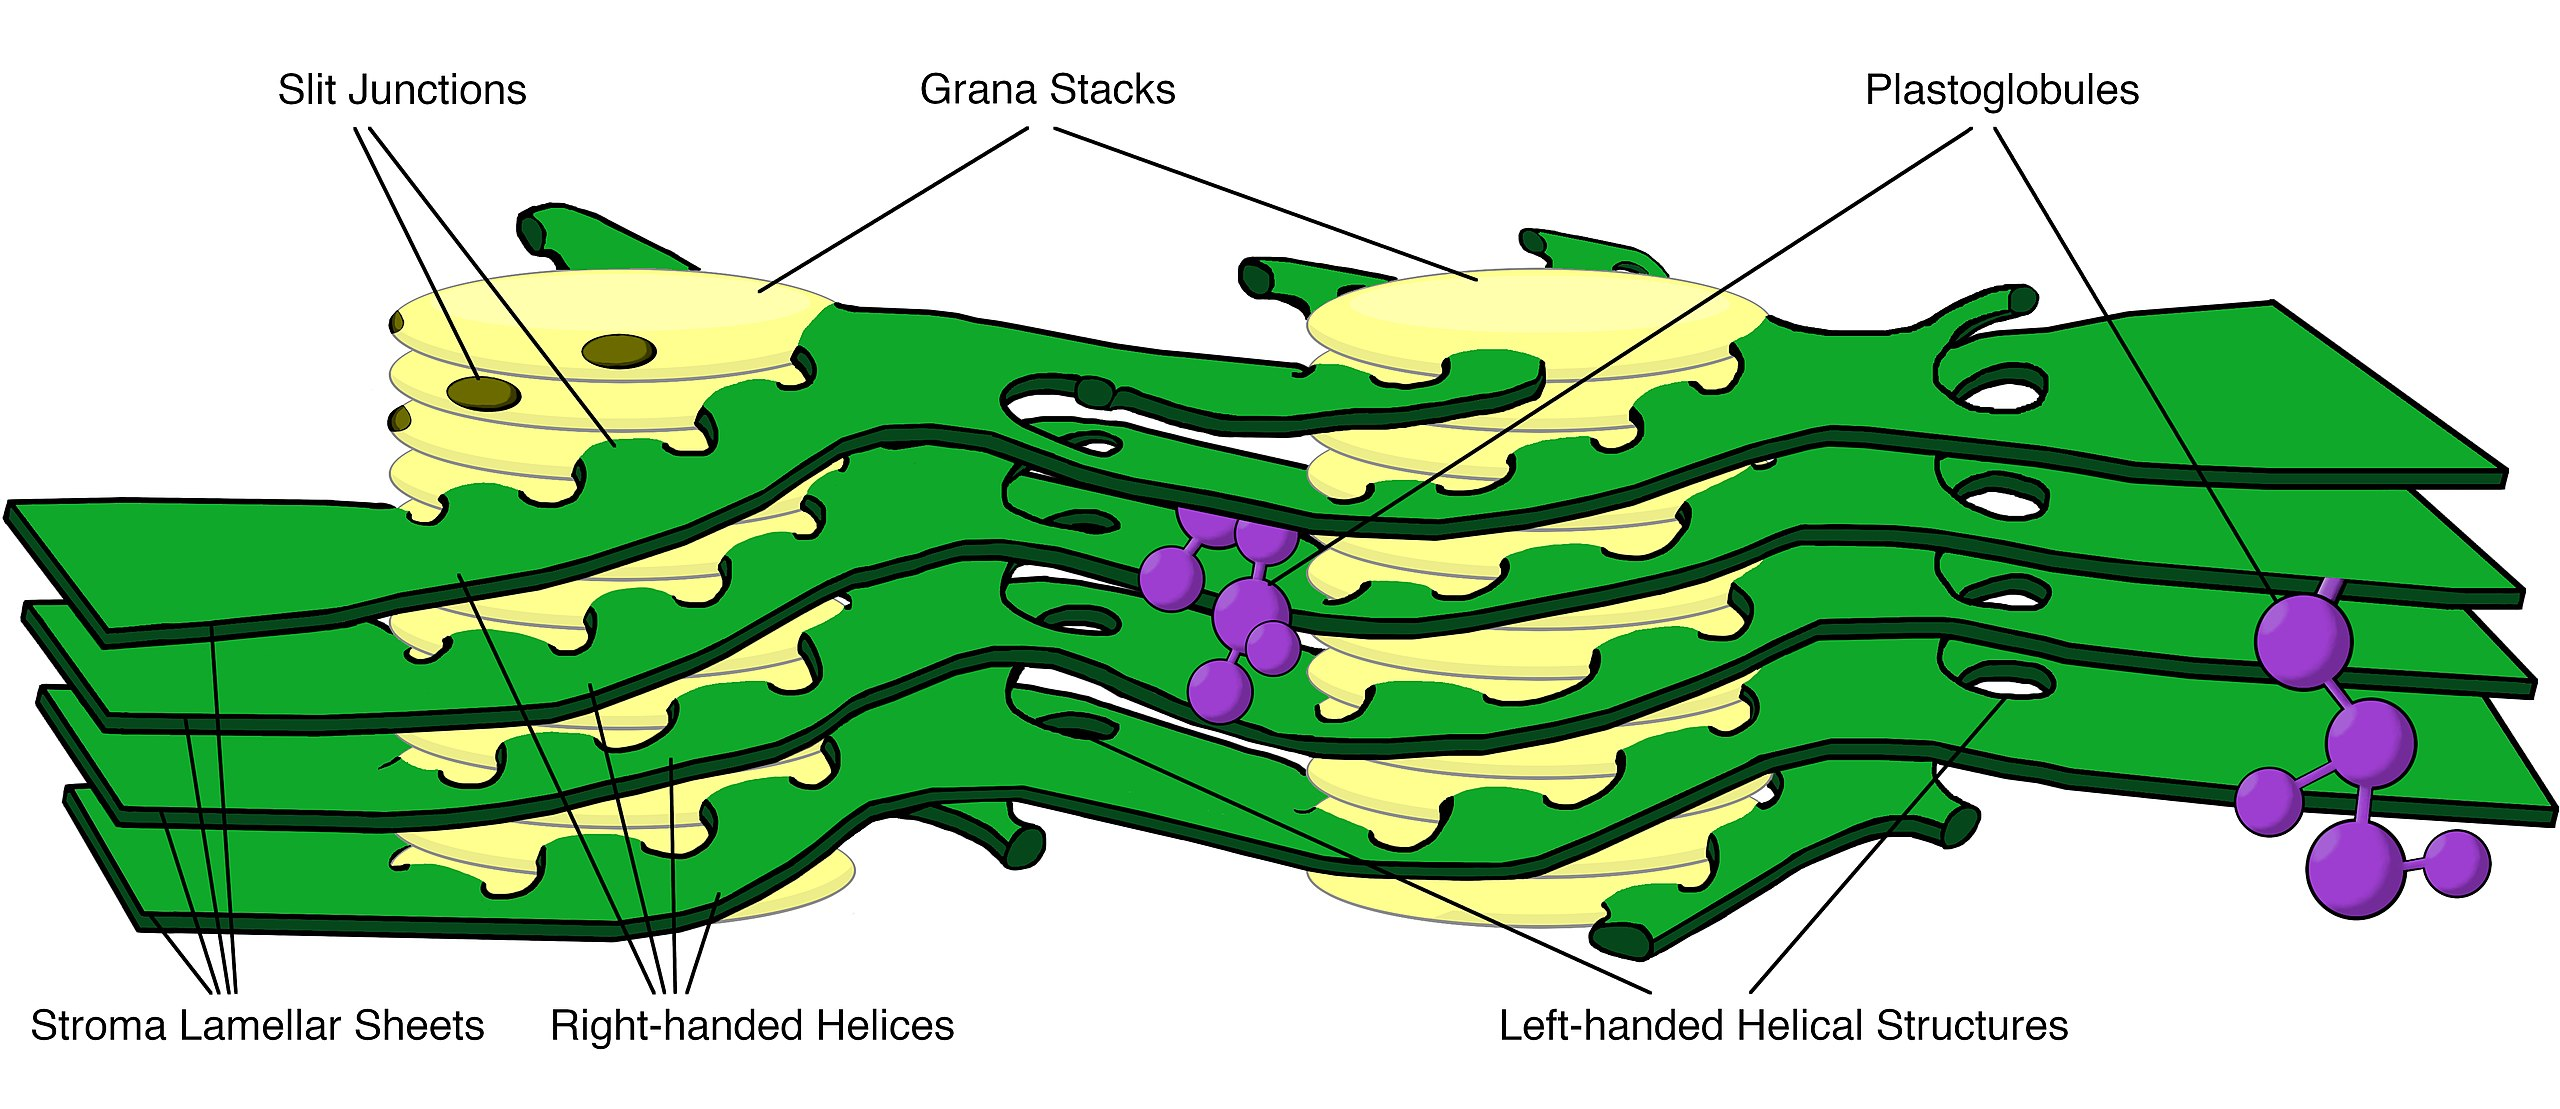

# Building the Grana Stacks with Ellipsoids

We will build the grana stacks using ellipsoids with **PyVista** and compare the results with the cryo-EM data.

In [195]:
#Dictionary with all the meshes from the cryo-em data by material color
meshes_by_material = {}
for mesh in cryo_mesh:
    if 'material_name' in mesh.array_names:
        material_name = mesh['material_name'][0]  # Assuming single material per mesh
        if material_name not in meshes_by_material:
            meshes_by_material[material_name] = []
        meshes_by_material[material_name].append(mesh)


In [197]:
dict_material_regions = {
    'grana': 'Material.001',
    'stroma': 'Material.007',
    'left_handed': 'Material.002',
    'right_handed': 'Material.005',
}

#Change keys to match the material names in the meshes

for key in dict_material_regions.keys():
    if dict_material_regions[key] in meshes_by_material:
        dict_material_regions[key] = meshes_by_material[dict_material_regions[key]]
    else:
        print(f"Warning: Material {dict_material_regions[key]} not found in meshes_by_material.")

In [178]:
#Plot all in a single view

ellipsoid_plot = pv.Plotter(window_size=[1600, 600])
ellipsoid_plot.background_color = 'white'
# Add the ellipsoids mesh
for ellipsoid in ellipsoids_mesh:
    ellipsoid_plot.add_mesh(ellipsoid, show_edges=True, color='y')

ellipsoid_plot.show()

Widget(value='<iframe src="http://localhost:41233/index.html?ui=P_0x7495cd4282b0_108&reconnect=auto" class="py…

In [13]:
#Try remeshing the original mesh
remesh = remesh_surface(ellipsoids_mesh[0], n_points=20000, subdivision=3) #HYPERPARAMETER: subdivision, more points are needed for better clustering
# plot uniformly remeshed ellipsoids
remesh.plot(color='w', show_edges=True)

Widget(value='<iframe src="http://localhost:37961/index.html?ui=P_0x7f6dd8a73d30_1&reconnect=auto" class="pyvi…

In [14]:
#Print current resolution
area = print_faces_area(remesh)
n_faces = remesh.n_faces
print(f"Number of faces: {n_faces}")
print(f"\nArea per face: {area.mean()} nm")

#Print dimensions of the mesh
print(f"Dimensions of the mesh: {remesh.bounds}")   

Number of faces: 39996
Mean area: 3.7965903290161855
Std area: 0.6484703019111498
Min area: 1.3302144117902999
Max area: 7.759922944846765
Number of faces: 39996

Area per face: 3.7965903290161855 nm
Dimensions of the mesh: BoundsTuple(x_min=-149.9614635847157, x_max=149.98009654111172, y_min=-149.62636224597716, y_max=149.7038919468663, z_min=-26.799999237060547, z_max=26.796359187345413)


In [15]:
#Subdivide the mesh to get more points
#remesh = remesh.subdivide(3)
#Print current resolution
#area = print_faces_area(remesh)
#n_faces = remesh.n_faces
#print(f"\nArea per face: {area.mean()} nm")


Number of faces: 313600
Mean area: 0.48467384182346934
Std area: 0.18270163983387266
Min area: 0.08653098544308728
Max area: 0.7247554812299499
Number of faces: 39996
Mean area: 3.7965903290161855
Std area: 0.6484703019111498
Min area: 1.3302144117902999
Max area: 7.759922944846765


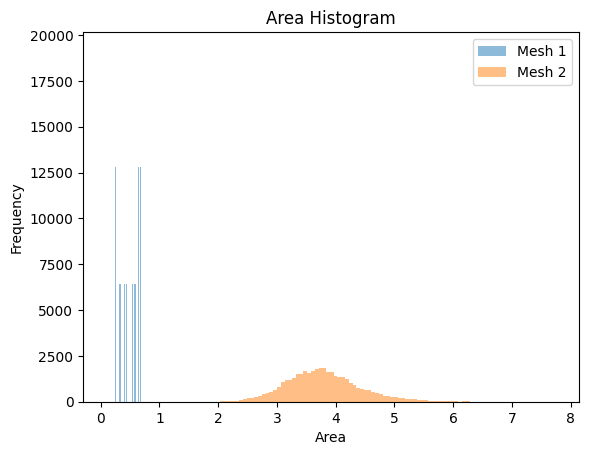

In [16]:
#Compare decimated and remeshed meshes
#Compute the area of the faces of the decimated mesh
area_0 = print_faces_area(ellipsoids_mesh[0])
#Compute the area of the faces of the remeshed mesh
area_1 = print_faces_area(remesh)
#Compare the area of the faces of two meshes
plot_area_histogram([area_0, area_1])

# Placing PSII randomly selecting points

In [17]:
#Sum area
print("Total area remeshed mesh: ", np.sum(area_1), "nm^2")
#Convert to um^2
total_area = np.sum(area_1) / 1e6
print("Total area remeshed mesh: ", total_area, "um^2")

Total area remeshed mesh:  151848.42679933136 nm^2
Total area remeshed mesh:  0.15184842679933136 um^2


In [18]:
#Concentration particles per um^2 Based on Engel 2024
concentration_psii=1415
concentration_cytb=446
n_psii=int(total_area*concentration_psii)
print("Number of PSII per granum: ", n_psii)
n_cytb=int(total_area*concentration_cytb)
print("Number of Cytb6f per granum: ", n_cytb)

Number of PSII per granum:  214
Number of Cytb6f per granum:  67


In [19]:
#ellipsoids_mesh[0]
# Select n random points from the ellipsoid
random_points, random_indices = select_random_points(remesh, 
                                                    n_points=n_psii, 
                                                    seed=42)  # Set seed for reproducibility

# Plot the ellipsoid with highlighted random points
plot_mesh_with_highlighted_points(remesh, 
                                  random_points,
                                  mesh_color='lightblue',
                                  point_color='yellow',
                                  point_size=11)

# If you want to print the indices of the selected points
n_random_points = len(random_indices)
print(f"Selected point indices: {n_random_points}")

Widget(value='<iframe src="http://localhost:37961/index.html?ui=P_0x7f6dd0287070_2&reconnect=auto" class="pyvi…

Selected point indices: 214


# Placing PSII matching NN distribution

###  Taken from Engel et. al. 2024 (Figure 6) 

### (A) Two main complexes in the grana region

![Screenshot from 2025-05-22 09-42-04.png](<attachment:Screenshot from 2025-05-22 09-42-04.png>)
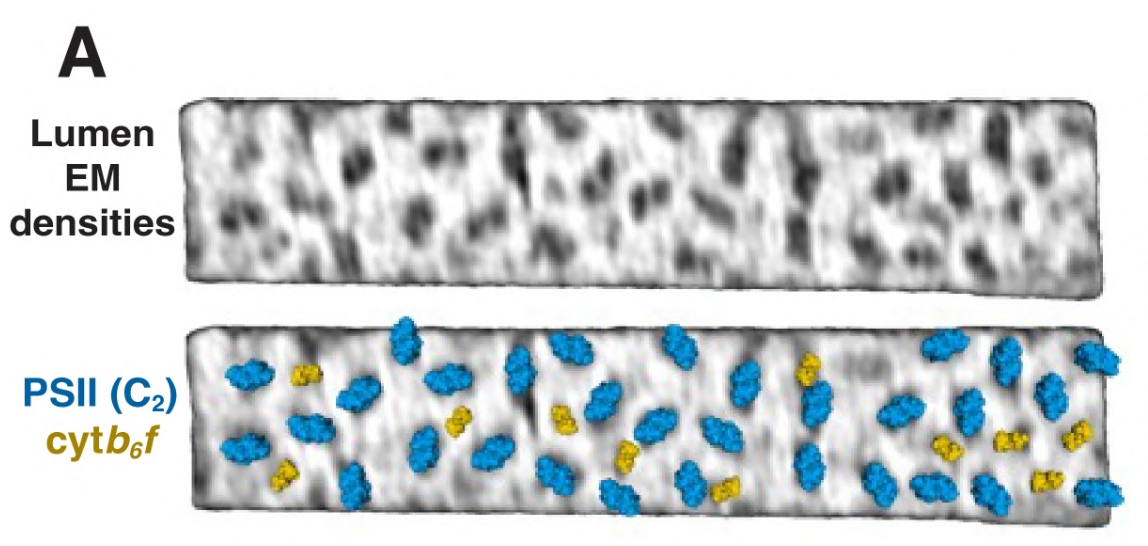

### (B) Nearest-Neighbor distances

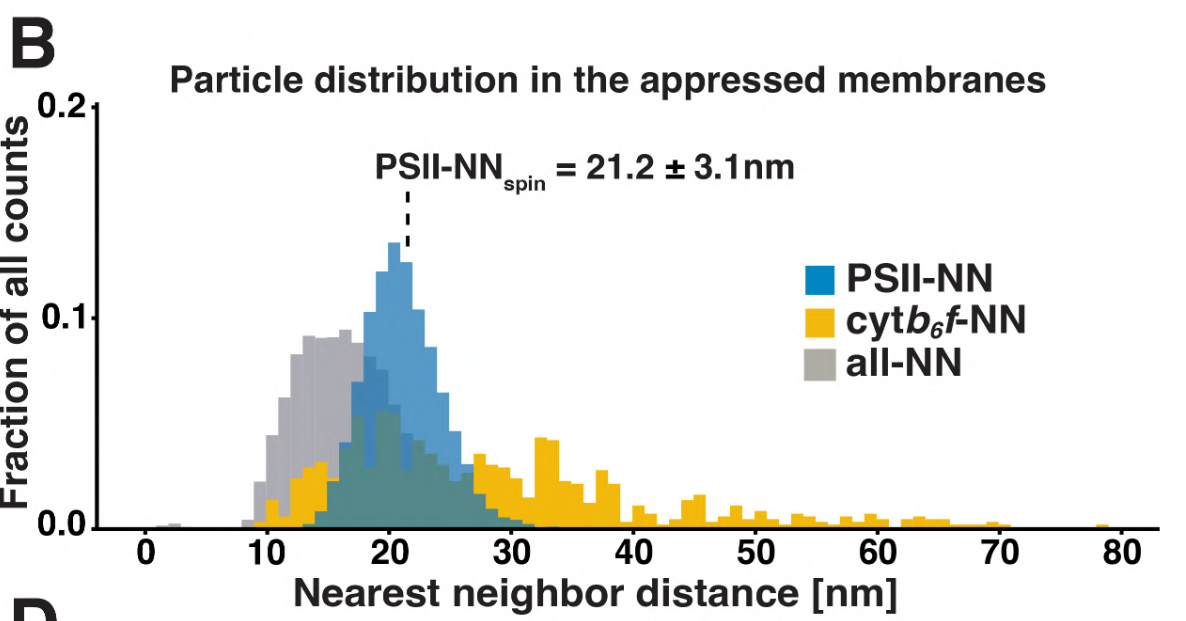

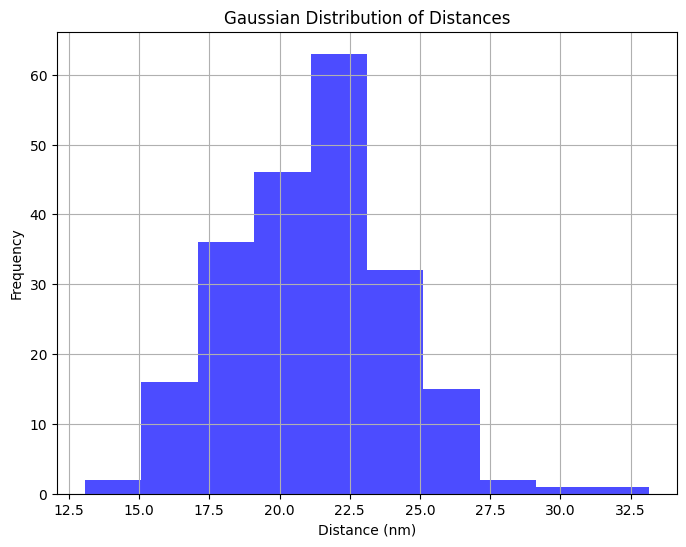

In [20]:
# Generate reference Gaussian distribution of points
gaussian_points = generate_nn_distances(n_psii, mean=21.2, std=3.1, seed=42)
# Plot the Gaussian distribution
plt.figure(figsize=(8, 6))
plt.hist(gaussian_points, bins=10, color='blue', alpha=0.7)
plt.xlabel('Distance (nm)')
plt.ylabel('Frequency')
plt.title('Gaussian Distribution of Distances')
plt.grid()
plt.show()

43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
Target distribution:  mean=25.00, std=0.20
Achieved distribution: mean=23.27, std=1.74


Widget(value='<iframe src="http://localhost:37961/index.html?ui=P_0x7f6dd024ee60_3&reconnect=auto" class="pyvi…

Target distribution: mean=21.20, std=3.10
Actual distribution: mean=23.27, std=1.74
KS test: statistic=0.4156, p-value=0.0000
Number of points distributed: 214


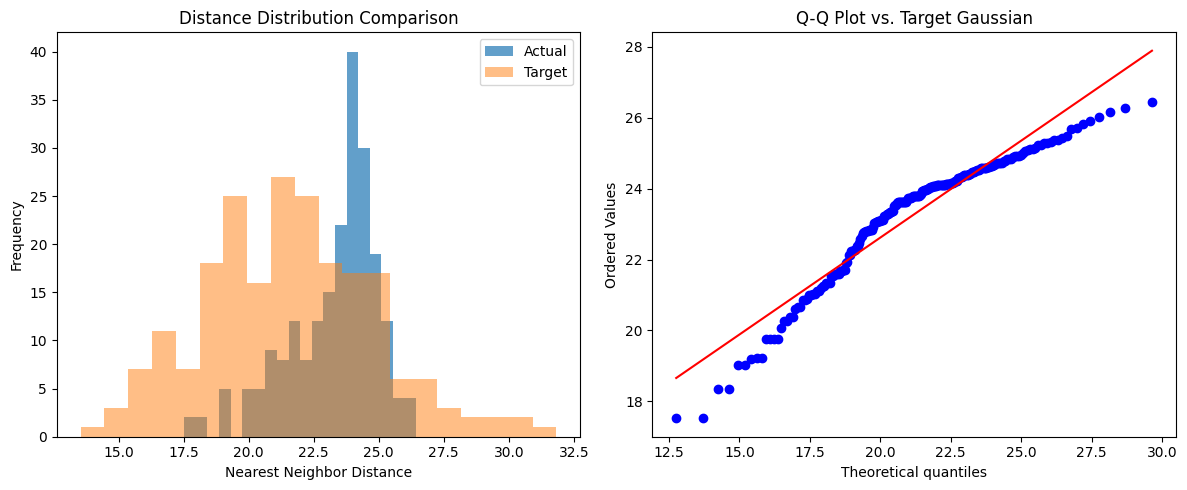

In [21]:
#From the paper, we want an average distance of 21.2 nm and a std deviation of 3.1 nm, but here we might need to adjust the target for the iteration

# Generate points on your mesh following a Gaussian NN-distance distribution
#distributed_points = distribute_points_gaussian(
#    mesh=remesh,
#    n_points=n_psii,  # Number of points you want
#    mean_distance=23,  # Your target mean distance
#    std_distance=1,    # Your target std deviation
#    seed=42             # For reproducibility
#)
distributed_points, forbidden_points = distribute_points_gaussian(
    mesh=remesh,
    n_points=n_psii,     # Number of points you want
    mean_distance=25,  # Your target mean distance
    std_distance=0.2,    # Your target std deviation
    max_attempts=10000, # Number of attempts to place each point
    forbiden_radius=10, # Radius of the forbidden cylinder (PSII size + 1.2 nm)
    forbiden_height=6,  # Height of the forbidden cylinder
    seed=42             # For reproducibility
)

# Visualize points on the mesh
plot_mesh_with_highlighted_spheres(
    mesh=remesh,
    highlighted_points=distributed_points,
    mesh_color='lightyellow',
    point_color='yellow',
    point_size=11 #PSII size
)

# Analyze how well the distribution matches the target Gaussian
analysis = analyze_point_distribution(
    points=distributed_points,
    target_mean=21.2,
    target_std=3.1
)

print(f"Target distribution: mean={analysis['target_mean']:.2f}, std={analysis['target_std']:.2f}")
print(f"Actual distribution: mean={analysis['actual_mean']:.2f}, std={analysis['actual_std']:.2f}")
print(f"KS test: statistic={analysis['ks_statistic']:.4f}, p-value={analysis['ks_pvalue']:.4f}")

n_points = len(distributed_points)
print(f"Number of points distributed: {n_points}")

In [22]:
print(distributed_points.dtype)
print(forbidden_points.dtype)

float64
float64


In [23]:
# Visualize points on the mesh
plot_mesh_with_highlighted_points(
    mesh=remesh,
    highlighted_points=forbidden_points,
    mesh_color='lightyellow',
    point_color='yellow',
    point_size=10 #PSII size
)


Widget(value='<iframe src="http://localhost:37961/index.html?ui=P_0x7f6dd0215a20_4&reconnect=auto" class="pyvi…

In [24]:
#Drop points in the mesh were we placed the PSII and 22nm around
def drop_points_in_sphere(mesh, points, radius=22):
    """
    Drop points in a sphere around the specified points on the mesh.
    
    Parameters
    ----------
    mesh : pyvista.PolyData
        The mesh from which to drop points.
        
    points : np.ndarray
        Array of shape (n_points, 3) containing the coordinates of the center points.
        
    radius : float, default: 22
        Radius of the sphere around each point where points will be dropped.
    
    Returns
    -------
    np.ndarray
        Array of shape (n_dropped_points, 3) containing the coordinates of the dropped points.
    """
    import numpy as np
    
    # Initialize list to store dropped points
    dropped_points = []
    
    # Iterate over each point
    for point in points:
        # Calculate distances from this point to all other points in the mesh
        distances = np.linalg.norm(mesh.points - point, axis=1)
        
        # Find indices of points within the specified radius
        indices_to_drop = np.where(distances <= radius)[0]
        
        # Append these points to the list of dropped points
        dropped_points.extend(mesh.points[indices_to_drop])
    
    return np.array(dropped_points)

def drop_points_in_cylinder(mesh, points, radius=22, height=10):
    """
    Drop points in a cylinder around the specified points on the mesh.
    
    Parameters
    ----------
    mesh : pyvista.PolyData
        The mesh from which to drop points.
        
    points : np.ndarray
        Array of shape (n_points, 3) containing the coordinates of the center points.
        
    radius : float, default: 22
        Radius of the cylinder around each point where points will be dropped.
        
    height : float, default: 10
        Height of the cylinder.
    
    Returns
    -------
    np.ndarray
        Array of shape (n_dropped_points, 3) containing the coordinates of the dropped points.
    """
    import numpy as np
    
    # Initialize list to store dropped points
    dropped_points = []
    
    # Iterate over each point
    for point in points:
        # Calculate distances from this point to all other points in the mesh
        distances = np.linalg.norm(mesh.points - point, axis=1)
        
        # Find indices of points within the specified radius and height
        indices_to_drop = np.where((distances <= radius) & 
                                    (np.abs(mesh.points[:, 2] - point[2]) <= height))[0]
        
        # Append these points to the list of dropped points
        dropped_points.extend(mesh.points[indices_to_drop])
    
    return np.array(dropped_points)




In [25]:
dropped_points = drop_points_in_cylinder(
    mesh=remesh,
    points=distributed_points,
    radius=11,  # Radius of the cylinder
    height=3   # Height of the cylinder
)
plot_mesh_with_highlighted_points(
    mesh=remesh,
    highlighted_points=dropped_points,
    mesh_color='lightyellow',
    point_color='red',
    point_size=5
)

Widget(value='<iframe src="http://localhost:37961/index.html?ui=P_0x7f6dd0216050_5&reconnect=auto" class="pyvi…

# Adding the cytochrome b6f

In [26]:
#Remove points from the mesh
#remesh_without_psii = remove_points_from_mesh(remesh, dropped_points)

In [27]:
#Try with the new mesh
distributed_points = distribute_points_gaussian(
    mesh=remesh_without_psii,
    n_points=n_cytb,  # Number of points you want
    mean_distance=40,  # Your target mean distance
    std_distance=5,    # Your target std deviation
    seed=42,             # For reproducibility
    clear_radius=1
)
# Visualize points on the mesh
plot_mesh_with_highlighted_points(
    mesh=remesh,
    highlighted_points=distributed_points,
    mesh_color='lightyellow',
    point_color='yellow',
    point_size=5
)

#Plot psii points to the mesh
plot_mesh_with_highlighted_points(
    mesh=remesh,
    highlighted_points=distributed_points,
    mesh_color='lightyellow',
    point_color='blue',
    point_size=5
)


NameError: name 'remesh_without_psii' is not defined

# Right-handed helix

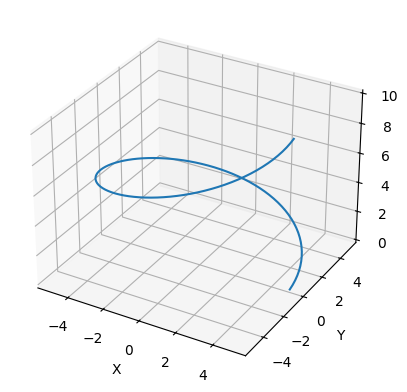

Widget(value='<iframe src="http://localhost:36621/index.html?ui=P_0x756832913880_11&reconnect=auto" class="pyv…

In [ ]:
# Generate a helix path (Note that n_points also counts the start and end points)
helix_points = simple_vertical_helix(height=10, radius=5, turns=1, n_points=101, handedness="right")
plot_spline_helix(helix_points)

# Create elliptical tube around the path
tube_mesh = create_elliptical_tube(
    helix_points, 
    major_radius=0.5, 
    minor_radius=1, 
    n_points=20 # Number of points in the cross-section
)

# Visualize
tube_mesh.plot(show_edges=True, color='lightblue')